In [2]:
import networkx as nx
import pandas as pd
import os
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Using readlines()
file1 = open('Sprint/topology.txt', 'r')
Lines = file1.readlines()
 
edges = []
# Strips the newline character
for line in Lines[1:-1]:
    to_node, from_node, cap, _ = line.split()
    edges.append((int(from_node), int(to_node), int(cap)))

In [4]:
G = nx.Graph() #directed
G.add_weighted_edges_from(edges)

In [5]:
file1 = open('Sprint/demand.txt', 'r')
lines = file1.readlines()
demands = []

for line in lines:
    demands.append(line.split())

demands = np.array(demands, dtype = float)
demands = np.max(demands, axis=0)

In [23]:
# maximize sum of flow for all paths - with undirected edges
# update edges
edges_undirected = []
for u, v in G.edges():
    tail = min(u,v)
    head = max(u,v)
    edges_undirected.append((tail, head, G[u][v]['weight']))

demand = [float(i) for i in line.split()]
n = int(len(demand)**0.5)
demand = np.array(demands).reshape(n, n)
paths = []
for i in range(n):
    for j in range(n):
        if i != j:
            paths.extend(list(nx.all_simple_edge_paths(G, i, j)))

# Create a new model
m = gp.Model("sprint")

edges_vars = {} #maps edge to (edge var, [path vars that use it])
for (src, dest, capacity) in edges_undirected:
    tail = min(src, dest)
    head = max(src, dest)
    edges_vars[(tail, head)] = (m.addVar(name=f'({tail}, {head})'), [])
    m.addConstr(edges_vars[(tail, head)][0] <= capacity, f'({tail}, {head})<={capacity}') #assuming >= 0 is already added)

demand_vars = {}

for i in range(n):
    for j in range(n):
        demand_vars[(i, j)] = (demand[i][j],[])

objective = 0

for path in paths:
    p = m.addVar(name=f'{path}')
    objective += p

    # add paths that try to satisfy a specific demand
    src, dest = path[0][0], path[-1][-1]
    demand_vars[(src, dest)][1].append(p)

    # this path uses edges --> need to 'credit' the edge
    for (node1, node2) in path:
        tail = min(node1, node2)
        head = max(node1, node2)
        edges_vars[(tail, head)][1].append(p)

#relating edge to path variables
for key in edges_vars:
    m.addConstr(edges_vars[key][0] == sum(edges_vars[key][1]))

# print(demand_vars)
for key in demand_vars:
    # print(demand_vars[key][0], sum(demand_vars[key][1]))
    if demand_vars[key][1]:
        m.addConstr(sum(demand_vars[key][1]) <= demand_vars[key][0])

# Set objective
m.setObjective(objective, GRB.MAXIMIZE)

# Optimize model
m.optimize()

# for v in m.getVars():
#     print('%s %g' % (v.VarName, v.X))

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-8279U CPU @ 2.40GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 146 rows, 4192 columns and 28210 nonzeros
Model fingerprint: 0xbcde3cef
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+09]
Presolve removed 146 rows and 4192 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.5364596e+07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds (0.01 work units)
Optimal objective  2.536459622e+07


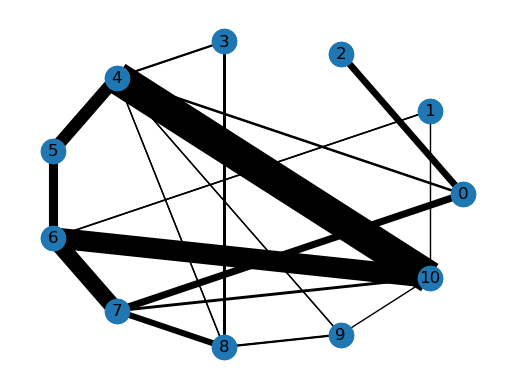

In [24]:
# VISUALIZATION
angles = np.linspace(0, 2*np.pi, 12)[:-1]
coords = [[np.cos(angles[i]), np.sin(angles[i])] for i in range(len(angles))]
pos = {}
for i in range(11):
    pos[i] = coords[i]
# get edge flows
max_flow_edges = []
bar_labels = []
flows = {}
modelVars = m.getVars()
for i in range(len(G.edges())):
    var = modelVars[i]
    edge = eval(var.VarName)
    flows[edge] = var.X
    max_flow_edges.append(var.X / 1e9)
    bar_labels.append(var.VarName)
nx.set_edge_attributes(G, flows, "flow")
nx.draw_networkx(G,pos)
# get edge widths
widths = []
for u,v in G.edges():
    widths.append(G[u][v]['flow'] / G[u][v]['weight']*1000)
nx.draw(G, pos, width=widths)
plt.savefig("max_flow_widths.png")

In [25]:
edges_vars_throughput = edges_vars
flows_throughput = flows

In [26]:
# Minimize the MLU (changing the objective function)

flow = 0 # represents the total flow sent on this network

paths = []
for i in range(n):
    for j in range(n):
        if i != j:
            paths.extend(list(nx.all_simple_edge_paths(G, i, j)))

# Create a new model
m = gp.Model("Min MLU - flow")

# new variable for current MLU
MLU = m.addVar(name="MLU")

edges_vars = {} # maps edge to (edge var, [path vars that use it])
for (src, dest, capacity) in edges_undirected:
    tail = min(src, dest)
    head = max(src, dest)
    edges_vars[(tail, head)] = (m.addVar(name=f'({tail}, {head})'), [])
    m.addConstr(edges_vars[(tail, head)][0] <= capacity, f'({src}, {tail})<={head}') # >= 0 is already added
    m.addConstr(edges_vars[(tail, head)][0] / capacity <= MLU)

demand_vars = {} # maps demand between two nodes to the path variables that constitute it

n = len(demand)
for i in range(n):
    for j in range(n):
        demand_vars[(i, j)] = (demand[i][j],[])


for path in paths:
    p = m.addVar(name=f'{path}')
    flow += p # add this path flow to our total flow accumulator

    # add paths that try to satisfy a specific demand
    src, dest = path[0][0], path[-1][-1]
    demand_vars[(src, dest)][1].append(p)

    # this path uses edges --> need to 'credit' the edge
    for (node1, node2) in path:
        tail = min(node1, node2)
        head = max(node1, node2)
        edges_vars[(tail, head)][1].append(p)

# relating edge to path variables
for key in edges_vars:
    m.addConstr(edges_vars[key][0] == sum(edges_vars[key][1]))

# do not send more than what is demanded
for key in demand_vars:
    if demand_vars[key][1]:
        m.addConstr(sum(demand_vars[key][1]) <= demand_vars[key][0])

# create a variable for the total flow in the network so we can retrieve its value after solving
total_flow = m.addVar(name="total_flow")
m.addConstr(total_flow == flow)

# Set objective
m.setObjective(MLU - total_flow/np.sum(demands), GRB.MINIMIZE) # minimize MLU but reward satisfying as much demand as possible

# Optimize model
m.optimize()

# for v in m.getVars():
#     print('%s %g' % (v.VarName, v.X))

print('Obj: %g' % m.ObjVal)
print('%g' % total_flow.X)

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-8279U CPU @ 2.40GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 165 rows, 4194 columns and 32421 nonzeros
Model fingerprint: 0x1bacf877
Coefficient statistics:
  Matrix range     [1e-09, 1e+00]
  Objective range  [4e-08, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+09]
Presolve removed 21 rows and 2 columns
Presolve time: 0.02s
Presolved: 144 rows, 4192 columns, 28225 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier performed 0 iterations in 0.04 seconds (0.01 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       1   -8.7454141e-01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.05 seconds (0.01 work units)
O

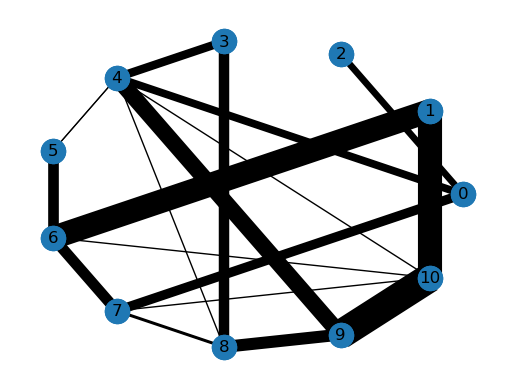

In [27]:
# VISUALIZATION
# get edge flows
flows = {}
modelVars = m.getVars()
MLU_objective = []
for i in range(1, len(G.edges())+1):
    var = modelVars[i]
    edge = eval(var.VarName)
    flows[edge] = var.X
    MLU_objective.append(var.X / 1e9)
nx.set_edge_attributes(G, flows, "flow")
nx.draw_networkx(G,pos)
widths = []
for u,v in G.edges():
    widths.append(G[u][v]['flow'] / G[u][v]['weight']*1000)
nx.draw(G, pos, width=widths)
plt.savefig("mlu_objective_widths.png")

In [28]:
edges_vars_mlu_objective = edges_vars
flows_mlu_objective = flows

In [29]:
# min the max problem - MLU (add extra constraint)
flow = 0

# demand = [float(i) for i in line.split()]
# n = int(len(demand)**0.5)
# demand = np.array(demand).reshape(n, n)
paths = []
for i in range(n):
    for j in range(n):
        if i != j:
            paths.extend(list(nx.all_simple_edge_paths(G, i, j)))

# Create a new model
m = gp.Model("ibm")

#new variable for MLU
MLU = m.addVar(name="MLU")

edges_vars = {} #maps edge to (edge var, [path vars that use it])
for (src, dest, capacity) in edges_undirected:
    tail = min(src, dest)
    head = max(src, dest)
    edges_vars[(tail, head)] = (m.addVar(name=f'({tail}, {head})'), [])
    m.addConstr(edges_vars[(tail, head)][0] <= capacity, f'({src}, {tail})<={head}') #assuming >= 0 is already added)
    m.addConstr(edges_vars[(tail, head)][0] / capacity <= MLU)

demand_vars = {}

n = len(demand)
for i in range(n):
    for j in range(n):
        demand_vars[(i, j)] = (demand[i][j],[])


for path in paths:
    p = m.addVar(name=f'{path}')
    flow += p

    # add paths that try to satisfy a specific demand
    src, dest = path[0][0], path[-1][-1]
    demand_vars[(src, dest)][1].append(p)

    # this path uses edges --> need to 'credit' the edge
    for (node1, node2) in path:
        tail = min(node1, node2)
        head = max(node1, node2)
        edges_vars[(tail, head)][1].append(p)

#relating edge to path variables
for key in edges_vars:
    m.addConstr(edges_vars[key][0] == sum(edges_vars[key][1]))

for key in demand_vars:
    if demand_vars[key][1]:
        m.addConstr(sum(demand_vars[key][1]) >= demand_vars[key][0])

total_flow = m.addVar(name="total_flow")
m.addConstr(total_flow == flow)

# Set objective
m.setObjective(MLU, GRB.MINIMIZE)

# Optimize model
m.optimize()

# for v in m.getVars():
#     print('%s %g' % (v.VarName, v.X))

print('%g' % total_flow.X)

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-8279U CPU @ 2.40GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 165 rows, 4194 columns and 32421 nonzeros
Model fingerprint: 0x0b42ba9b
Coefficient statistics:
  Matrix range     [1e-09, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+09]
Presolve removed 21 rows and 3 columns
Presolve time: 0.02s
Presolved: 144 rows, 4191 columns, 28224 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.178e+03
 Factor NZ  : 3.090e+03 (roughly 2 MB of memory)
 Factor Ops : 7.795e+04 (less than 1 second per iteration)
 Threads    : 1

Barrier performed 0 iterations in 0.04 seconds (0.01 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Iteration    Object

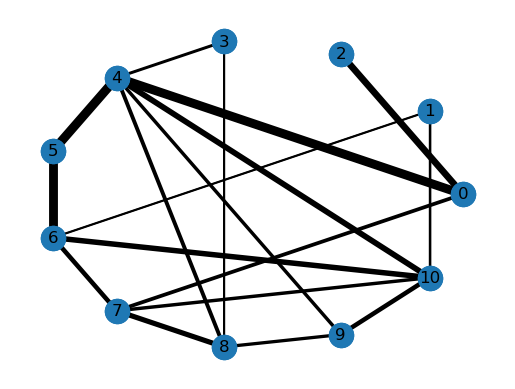

In [30]:
# VISUALIZATION
# get edge flows
flows = {}
modelVars = m.getVars()
MLU_constraint = []
for i in range(1, len(G.edges())+1):
    var = modelVars[i]
    edge = eval(var.VarName)
    flows[edge] = var.X
    MLU_constraint.append(var.X / 1e9)
nx.set_edge_attributes(G, flows, "flow")
nx.draw_networkx(G,pos)
widths = []
for u,v in G.edges():
    widths.append(G[u][v]['flow'] / G[u][v]['weight']*1000)
nx.draw(G, pos, width=widths)
plt.savefig("mlu_constraint_widths.png")

In [31]:
edges_vars_mlu_constraint = edges_vars
flows_mlu_constraint = flows

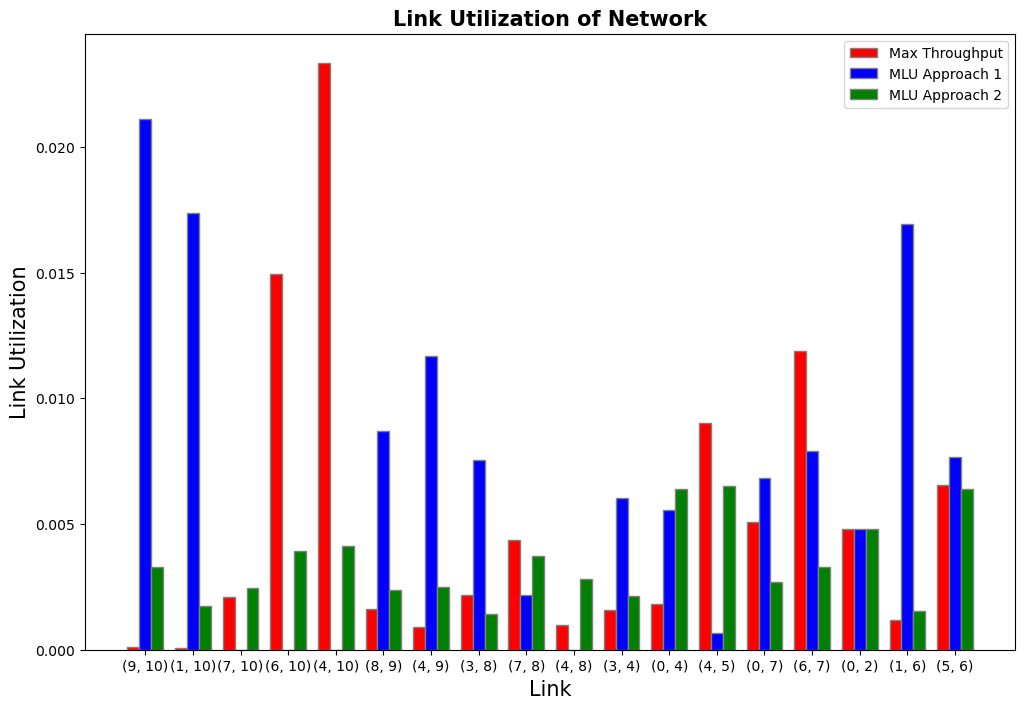

In [33]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# Set position of bar on X axis
br1 = np.arange(len(max_flow_edges))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, max_flow_edges, color ='r', width = barWidth,
        edgecolor ='grey', label ='Max Throughput')
plt.bar(br2, MLU_objective, color ='b', width = barWidth,
        edgecolor ='grey', label ='MLU Approach 1')
plt.bar(br3, MLU_constraint, color ='g', width = barWidth,
        edgecolor ='grey', label ='MLU Approach 2')

 
# Adding Xticks
plt.xlabel('Link', fontsize = 15)
plt.ylabel('Link Utilization', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(max_flow_edges))],bar_labels)
plt.title('Link Utilization of Network', fontweight ='bold', fontsize = 15)
 
plt.legend()
# plt.show()
plt.savefig("LU_bar_plot_presentation.png")

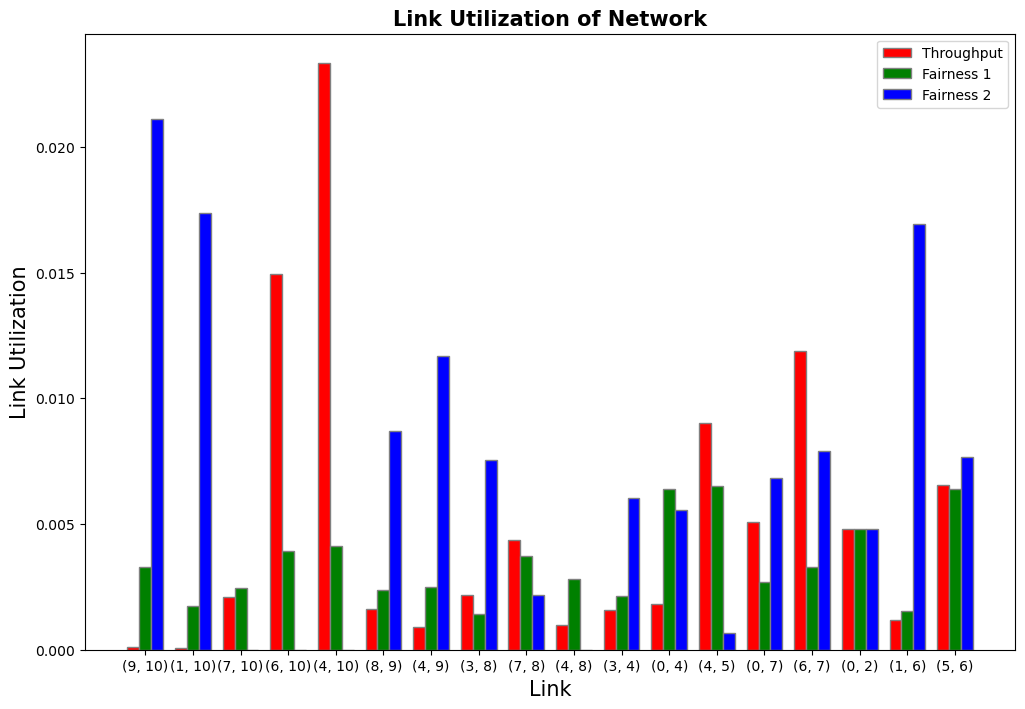

In [37]:
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# Set position of bar on X axis
br1 = np.arange(len(max_flow_edges))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, max_flow_edges, color ='r', width = barWidth,
        edgecolor ='grey', label ='Throughput')
plt.bar(br2, MLU_constraint, color ='g', width = barWidth,
        edgecolor ='grey', label ='Fairness 1')
plt.bar(br3, MLU_objective, color ='b', width = barWidth,
        edgecolor ='grey', label ='Fairness 2')

# Adding Xticks
plt.xlabel('Link', fontsize = 15)
plt.ylabel('Link Utilization', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(max_flow_edges))],bar_labels)
plt.title('Link Utilization of Network', fontweight ='bold', fontsize = 15)
 
plt.legend()
# plt.show()
plt.savefig("LU_bar_plot_report.png")

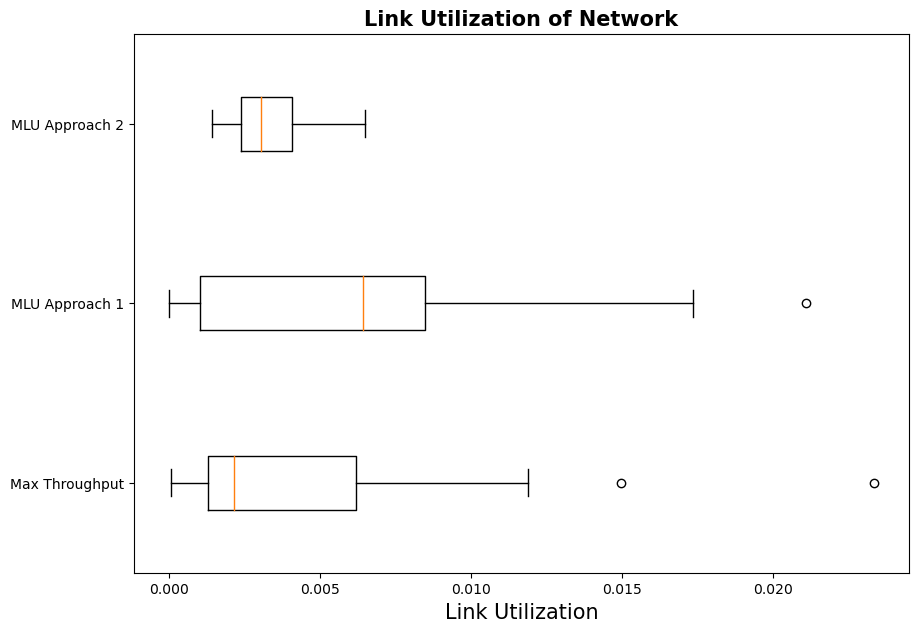

In [35]:
data = [max_flow_edges, MLU_objective, MLU_constraint]
 
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(data, vert = False)

plt.yticks([1, 2, 3], ['Max Throughput', 'MLU Approach 1', 'MLU Approach 2'])
plt.xlabel('Link Utilization', fontsize = 15)
plt.title('Link Utilization of Network', fontweight ='bold', fontsize = 15)
 
# show plot
# plt.show()
plt.savefig("LU_box_plot_presentation.png")

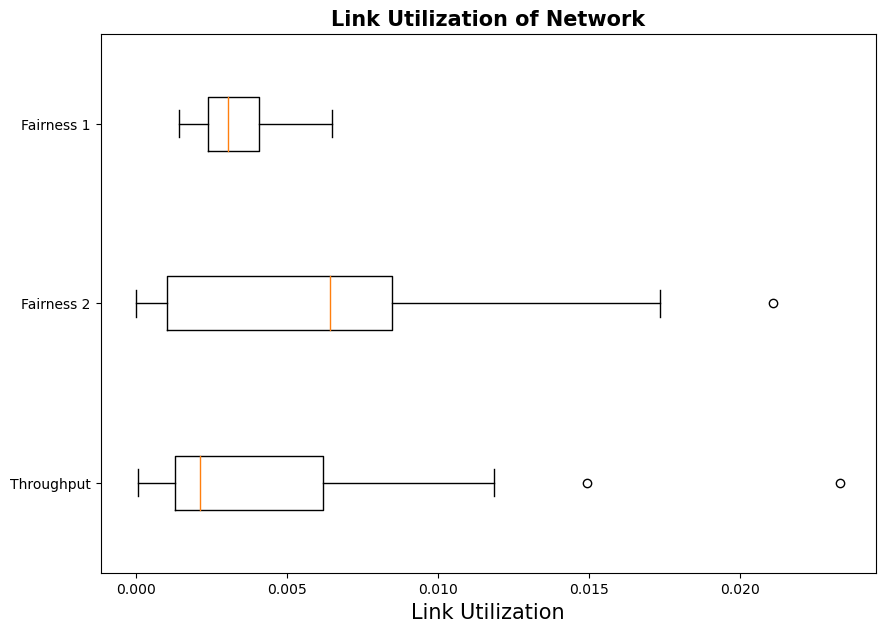

In [36]:
data = [max_flow_edges, MLU_objective, MLU_constraint]
 
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(data, vert = False)

plt.yticks([1, 2, 3], ['Throughput', 'Fairness 2', 'Fairness 1'])
plt.xlabel('Link Utilization', fontsize = 15)
plt.title('Link Utilization of Network', fontweight ='bold', fontsize = 15)
 
# show plot
# plt.show()
plt.savefig("LU_box_plot_report.png")

In [21]:
def get_max_edge_and_flow(flows):
    max_value = 0
    max_edge = None
    for key in flows:
        flow = flows[key]
        if flow > max_value:
            max_value = flow
            max_edge = key
    return max_value, max_edge

max_value_throughput, max_edge_throughput = get_max_edge_and_flow(flows_throughput)

max_value_mlu_constraint, max_edge_mlu_constraint = get_max_edge_and_flow(flows_mlu_constraint)

max_value_mlu_objective, max_edge_mlu_objective = get_max_edge_and_flow(flows_mlu_objective)
    
print('For Max Throughput, edge %s has the highest link utilization of %f, with %g Gbps throughput.' 
      % (max_edge_throughput, max_value_throughput / 1e9, max_value_throughput))
    
print('For MLU Approach 1 - constraint, edge %s has the highest link utilization of %f, with %g Gbps throughput.' 
      % (max_edge_mlu_constraint, max_value_mlu_constraint / 1e9, max_value_mlu_constraint))
    
print('For MLU Approach 2 - objective, edge %s has the highest link utilization of %f, with %g Gbps throughput.' 
      % (max_edge_mlu_objective, max_value_mlu_objective / 1e9, max_value_mlu_objective))
      

For Max Throughput, edge (4, 10) has the highest link utilization of 0.023329, with 2.3329e+07 Gbps throughput.
For MLU Approach 1 - constraint, edge (4, 5) has the highest link utilization of 0.006493, with 6.49286e+06 Gbps throughput.
For MLU Approach 2 - objective, edge (9, 10) has the highest link utilization of 0.021087, with 2.10869e+07 Gbps throughput.
